In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from featurewiz import FeatureWiz, cross_val_model_predictions
from featurewiz import print_regression_metrics, print_classification_metrics,print_sulo_accuracy

Imported lazytransform v1.11. 

Imported featurewiz 0.5.2. Use the following syntax:
    >>> wiz = FeatureWiz(feature_engg = '', nrows=None, transform_target=True, scalers="std",
        		category_encoders="auto", add_missing=False, verbose=0. imbalanced=False,
        		ae_options={})
    >>> X_train_selected, y_train = wiz.fit_transform(X_train, y_train)
    >>> X_test_selected = wiz.transform(X_test)
    >>> selected_features = wiz.features
    


In [3]:
trainfile = 'c:/users/ram/documents/ram/data_sets/kaggle/diabetes.csv'
datapath = '../Ram/Data_Sets/'
filename = 'winequality.csv'
filename = 'affairs.csv'
#filename = 'shark_attacks.csv'
trainfile = datapath+filename
sep = ','
dft = pd.read_csv(trainfile,sep=sep)
dft.drop(['affair','affairs'],axis=1, inplace=True)
print(dft.shape)
dft.head()

(6366, 9)


,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affair_multiclass
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4


In [4]:
from featurewiz import LazyTransformer, get_class_distribution, get_class_weights

In [5]:
target = 'affair_multiclass'
#target = 'quality'
modeltype = 'Multi_Classification'
#modeltype = 'Regression'
preds = [x for x in list(dft) if x not in target]
dft[target].nunique()

7

In [6]:
from sklearn.model_selection import train_test_split
from featurewiz import FE_kmeans_resampler
if modeltype == 'Regression':
    X_train, X_test, y_train, y_test = train_test_split(dft[preds], dft[target], test_size=0.20, random_state=1,)
    X_train_over, y_train_over = FE_kmeans_resampler(X_train, y_train, target, smote='',verbose=0)
    print(X_train_over.shape, X_test.shape)
    #train, test = pd.concat([X_train_over, pd.Series(y_train_over,name=target)], axis=1), pd.concat([X_test, y_test], axis=1)
    train, test = train_test_split(dft, test_size=0.20, random_state=42)
else:
    X_train, X_test, y_train, y_test = train_test_split(dft[preds], dft[target], test_size=0.20, 
                                                    stratify=dft[target],
                                                    random_state=42)
    train, test = train_test_split(dft, test_size=0.20, random_state=42,
                                                    stratify=dft[target]
                                                   )
print(X_train.shape, X_test.shape)

(5092, 8) (1274, 8)


<AxesSubplot:xlabel='affair_multiclass', ylabel='Probability'>

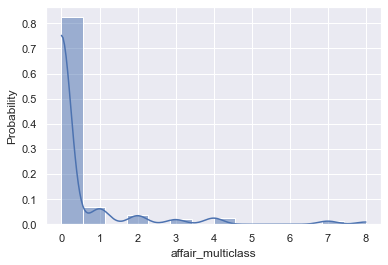

In [7]:
### Notice that the target values distribution is bimodal. 
import seaborn as sns
sns.set(rc={'figure.figsize':(20,5)})
sns.histplot(y_train, kde=True, stat="probability")

<AxesSubplot:xlabel='affair_multiclass', ylabel='Probability'>

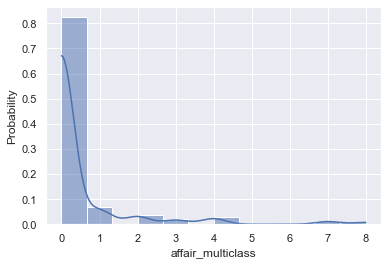

In [8]:
sns.histplot(y_test, kde=True, stat="probability")

In [9]:
import scipy.stats as spy
## If y is log, then set this flag
log_y = False
if (abs(spy.skew(y_train)) >= 3.0) & (modeltype=='Regression'):
    log_y = True
print(log_y)

# Assuming 'affairs' is the target variable in your train and test sets
if log_y & (modeltype == 'Regression'):
    y_train = np.log(y_train + 1)
    y_test = np.log(y_test + 1)

False


In [10]:
## set feature_engg flag here
fe = False

In [11]:
def feature_engg_for_affairs(df):
    df = df.copy(deep=True)
    # Feature engineering
    df['age_yrs_married_interaction'] = df['age'] * df['yrs_married']
    df['children_to_yrs_married_ratio'] = df['children'] / df['yrs_married']
    df['is_childless'] = (df['children'] == 0).astype(int)
    df['age_group'] = pd.cut(df['age'], bins=[20, 30, 40, 50, 60], labels=['20s', '30s', '40s', '50s'])
    df['marriage_satisfaction_age'] = df['rate_marriage'] * df['age']

    # Now df contains the original features plus the new engineered features
    print(df.shape)
    return df

In [12]:
if fe:
    X_train = feature_engg_for_affairs(X_train)
    X_test = feature_engg_for_affairs(X_test)

In [13]:
# Generate polynomial features
from sklearn.preprocessing import PolynomialFeatures
cols = ['rate_marriage', 'age', 'yrs_married', 'children']
poly = PolynomialFeatures(degree=2, include_bias=False)

In [14]:
if fe:
    poly_features = poly.fit_transform(X_train[cols])
    poly_feature_names = poly.get_feature_names_out(cols)
    df_poly = pd.DataFrame(poly_features, columns=poly_feature_names)
    # Merge the polynomial features back into the original dataframe
    X_train = X_train.join(df_poly, rsuffix='_extra').drop(cols, axis=1)
    print(X_train.shape)

    poly_features = poly.transform(X_test[cols])
    poly_feature_names = poly.get_feature_names_out(cols)
    df_poly = pd.DataFrame(poly_features, columns=poly_feature_names)
    # Merge the polynomial features back into the original dataframe
    X_test = X_test.join(df_poly, rsuffix='_extra').drop(cols, axis=1)
    print(X_test.shape)

In [15]:
### For regression, dae_add gives only okay results, try VAE instead
dae_dicto = {
    'noise_factor': 0.2,
    'encoding_dim': 10,
    'epochs': 100, 
    'batch_size': 32,
         }
dae_dicto = {}
### VAE_ADD gives better results than VAE and DAE. Try it first for Regression problems.
vae_dicto = {
    'intermediate_dim': 32,
    'latent_dim': 8,
    'epochs': 100, 
    'batch_size': 32,
    'learning_rate': 0.001
         }
gan_dicto = {
    'gan_model':None,
    'input_dim': 100,
    'embedding_dim': 100, 
    'epochs': 100, 
    'num_synthetic_samples': 400,
         }

In [16]:
fwiz = FeatureWiz(feature_engg = 'dae_add', nrows=None, transform_target=True, scalers="MinMax",
        		category_encoders="one-hot", add_missing=False, verbose=0, imbalanced=False,
                   ae_options=dae_dicto, skip_sulov=False, skip_xgboost=False)

featurewiz is given 0.9 as correlation limit...
    final list of feature engineering given: ['dae_add']
    final list of category encoders given: ['label', 'label']
Since Auto Encoders are selected for feature extraction,
    Recursive XGBoost is skipped...
DenoisingAutoEncoder()
    AE dictionary given: dict_items([])
    final list of scalers given: [minmax]


In [17]:
# Load and preprocess your dataset
# Assuming X_train and y_train are your training data and labels
X_train_selected, encoded_y_train = fwiz.fit_transform(X_train, y_train)

Loaded input data. Shape = (5092, 8)
Performing hyper param selection for DAE. Will take approx. 81 seconds
    defining a pipeline with MinMaxScaler and DAE
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Epoch 1/3
255/255 [==============================] - 3s 5ms/step - loss: 0.3987 - mse: 0.3987 - val_loss: 0.0737 - val_mse: 0.0737
Epoch 2/3
255/255 [==============================] - 1s 3ms/step - loss: 0.1282 - mse: 0.1282 - val_loss: 0.0542 - val_mse: 0.0542
Epoch 3/3
255/255 [==============================] - 1s 4ms/step - loss: 0.0887 - mse: 0.0887 - val_loss: 0.0474 - val_mse: 0.0474
    time taken for DAE hyper param selection = 67 seconds
{'feature_extractor__batch_size': 16, 'feature_extractor__encoding_dim': 5, 'feature_extractor__epochs': 3}
#### Starting featurewiz transform for train data ####
No groupby features created since no groupby feature engg specified
No interactions created for categorical vars since no interactions feature engg specified
    Single

In [18]:
### Since you modified y_train to numeric, you must do same for y_test
X_test_selected = fwiz.transform(X_test)
if modeltype !='Regression':
    y_test = fwiz.lazy.yformer.transform(y_test)

#### Starting featurewiz transform for test data ####
Loaded input data. Shape = (1274, 8)
    Beware! feature_engg will add 100s, if not 1000s of additional features to your dataset!
#### Starting lazytransform for test data ####
    Time taken to transform dataset = 1 second(s)
    Shape of transformed dataset: (1274, 8)
Shape of transformed data due to auto encoder = (1274, 13)
Returning dataframe with 11 features 


In [19]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, classification_report
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# Updating the Random Forest Classifier with the corrected class weights
if modeltype == 'Regression':
    rf_classifier = RandomForestRegressor(random_state=42)
else:
    # Correctly computing class weights for the classes present in the training set
    class_weights_dict_corrected = get_class_distribution(y_train)
    rf_classifier = RandomForestClassifier(class_weight=class_weights_dict_corrected, random_state=42)


# Fitting the classifier on the training data
rf_classifier.fit(X_train_selected, y_train)

# Predicting on the test set
y_pred = rf_classifier.predict(X_test_selected)

if modeltype == 'Regression':
    print_regression_metrics(y_test, y_pred, verbose=1)
else:
    # Evaluating the classifier
    y_probas = rf_classifier.predict_proba(X_test_selected)
    print_classification_metrics(y_test, y_pred, y_probas, verbose=1)

Bal accu 15%
ROC AUC = 0.68
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1050
           1       0.14      0.05      0.07        86
           2       0.18      0.04      0.07        48
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        35
           5       0.00      0.00      0.00        17
           6       0.00      0.00      0.00        12
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0

    accuracy                           0.80      1274
   macro avg       0.13      0.12      0.11      1274
weighted avg       0.70      0.80      0.74      1274

final average balanced accuracy score = 0.15


In [20]:
from featurewiz.ml_models import IterativeClassifier, IterativeForwardClassifier, IterativeBackwardClassifier
from featurewiz import IterativeDoubleClassifier

In [21]:
# Example usage
# Create and train the classifier
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, classification_report
import time
start_time = time.time()

# Updating the Random Forest Classifier with the corrected class weights
if modeltype == 'Regression':
    rf_classifier = RandomForestRegressor(random_state=42)
else:
    # Correctly computing class weights for the classes present in the training set
    class_weights_dict_corrected = get_class_weights(y_train)
    ### The Double Classifier is best of the bunch!  It provides very high ROC_AUC but low bal_accuracy
    rf_classifier = IterativeDoubleClassifier( weights = {1: 0.5, 2: 0.5} )
    ### The Iterative Classifier is somewhat worse than a regular classifier. Don't know why.
    #rf_classifier = IterativeClassifier( threshold=100)


# Fitting the classifier on the training data
rf_classifier.fit(X_train_selected, y_train)

# Predicting on the test set
y_pred = rf_classifier.predict(X_test_selected)

if modeltype == 'Regression':
    print_regression_metrics(y_test, y_pred, verbose=1)
else:
    # Evaluating the classifier
    y_probas = rf_classifier.predict_proba(X_test_selected)
    print_classification_metrics(y_test, y_pred, y_probas, verbose=1)
print('Time taken = %0.0f seconds' %(time.time()-start_time))

Bal accu 14%
ROC AUC = 0.75
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      1050
           1       0.00      0.00      0.00        86
           2       0.00      0.00      0.00        48
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        35
           5       0.00      0.00      0.00        17
           6       0.00      0.00      0.00        12

    accuracy                           0.82      1274
   macro avg       0.12      0.14      0.13      1274
weighted avg       0.68      0.82      0.74      1274

final average balanced accuracy score = 0.14
Time taken = 7 seconds
